# Signal + Background Model
In this example a model made of a signal and a background is employed.

In [1]:
import mplhep
import numpy as np

import zfit

mplhep.style.use("LHCb2")
import matplotlib.pyplot as plt

/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


Model is created below

In [2]:
# create space
obs = zfit.Space("x", limits=(-10, 10))

# parameters
mu = zfit.Parameter("mu", 1.0, -4, 6)
sigma = zfit.Parameter("sigma", 1.0, 0.1, 10)
lambd = zfit.Parameter("lambda", -0.06, -1, -0.01)
frac = zfit.Parameter("fraction", 0.3, 0, 1)

# model building, pdf creation
gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
exponential = zfit.pdf.Exponential(lambd, obs=obs)
model = zfit.pdf.SumPDF([gauss, exponential], fracs=frac)


Data is generated from the above model by means of 
```python
data = model.create_sampler(nevs)
data.resample()
```

In [14]:

# data
n_sample = 10000

exp_data = exponential.sample(n=n_sample * (1 - frac)).numpy()

gauss_data = gauss.sample(n=n_sample * frac).numpy()

data = model.create_sampler(n_sample, limits=obs)
data.resample()

# change values for showing the effect of the fit

mu.set_value(0.5)
sigma.set_value(1.2)
lambd.set_value(-0.05)
frac.set_value(0.07)



Data and model before fitting are shown

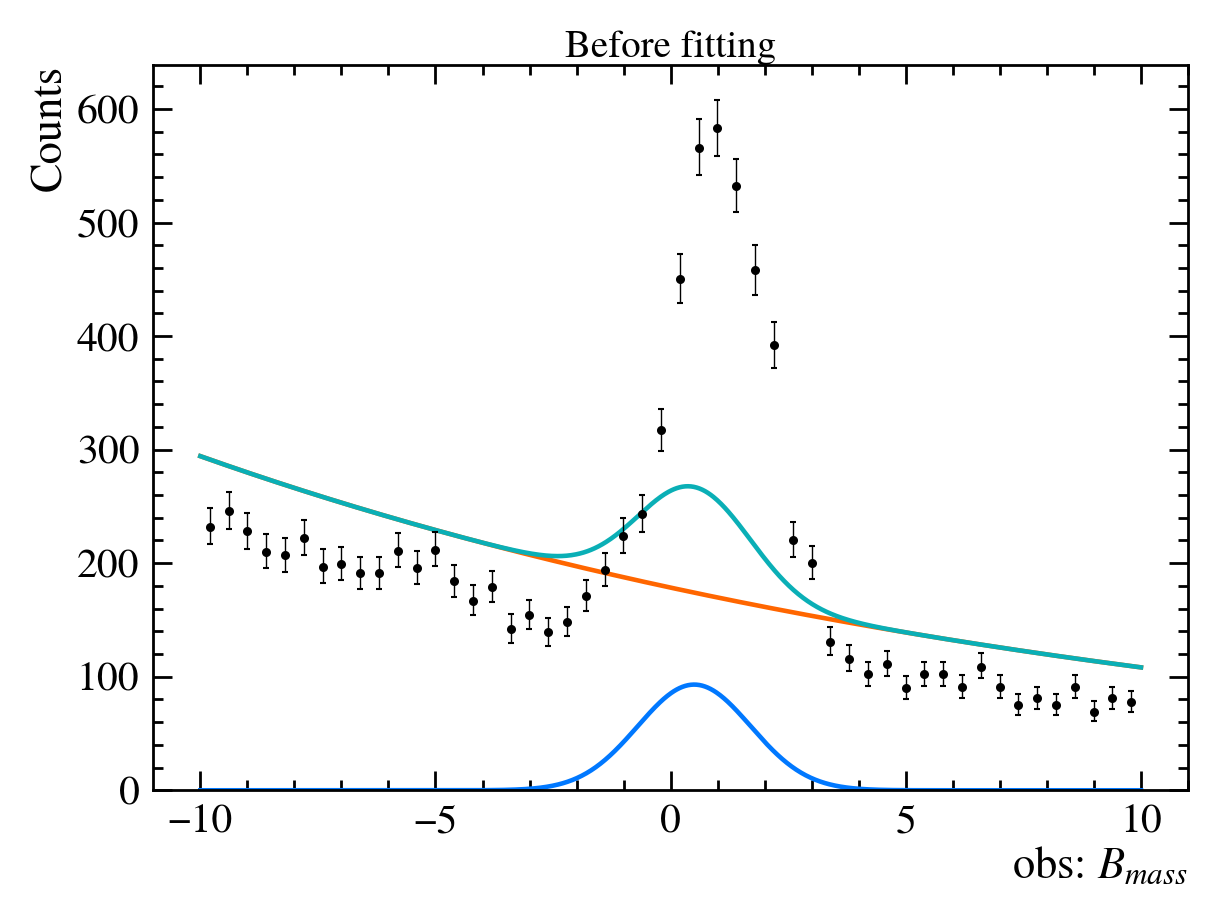

In [4]:
# plot the data
data_np = data.numpy()
n_bins = 50

plot_scaling = n_sample / n_bins * obs.area()

x = np.linspace(-10, 10, 1000)


def plot_pdf(title):
    plt.figure()
    plt.title(title)
    y = model.pdf(x).numpy()
    y_gauss = (gauss.pdf(x) * frac).numpy()
    y_exp = (exponential.pdf(x) * (1 - frac)).numpy()
    plt.plot(x, y_gauss * plot_scaling, label="Gauss - Signal")
    plt.plot(x, y_exp * plot_scaling, label="Exp - Background")
    plt.plot(x, y * plot_scaling, label="Sum - Model")
    mplhep.histplot(
        np.histogram(data_np, bins=n_bins),
        yerr=True,
        color="black",
        histtype="errorbar",
    )
    plt.ylabel("Counts")
    plt.xlabel("obs: $B_{mass}$")


# plot the pdf BEFORE fitting
plot_pdf("Before fitting")


Run the fit

/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/minimizers/fitresult.py:1318: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(
/Users/maurizio/Software/zfit/lib/python3.10/site-packages/zfit/minimizers/fitresult.py:1341: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.errors_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of errors (which is currently the method name such as `minuit_minos`or `zfit_errors`) has changed to `errors`. Old names are still added as well for compatibility but will be removed in the future. INSTRUCTIONS: to stay compatible, change wherever you access the error to 'errors' or specify the name expli

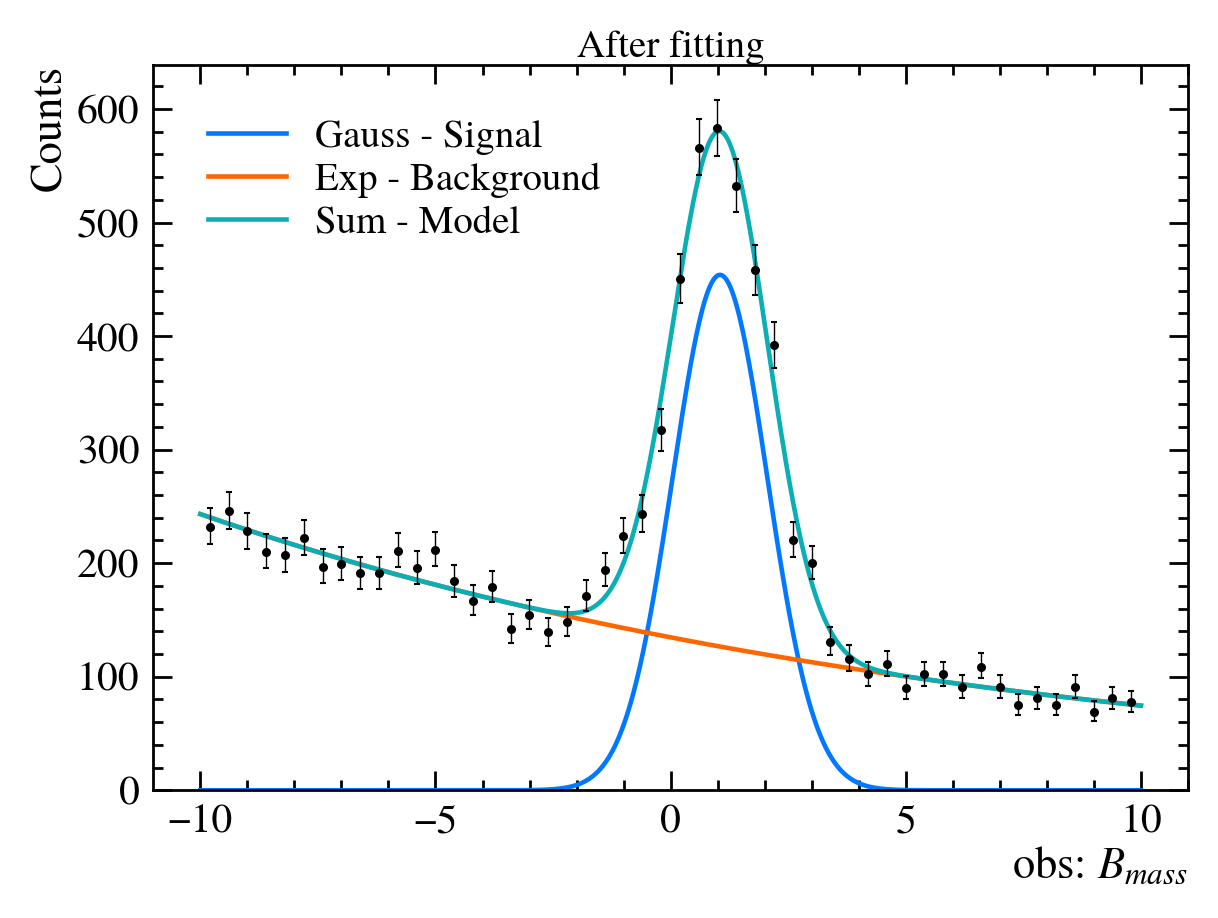

In [5]:
# create NLL
nll = zfit.loss.UnbinnedNLL(model=model, data=data)

# create a minimizer
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)

# do the error calculations, here with minos
param_errors, _ = result.errors()

plot_pdf(title="After fitting")
plt.legend()

Make nicer plot

In [6]:
import os, sys
sys.path.append(f'{os.environ["PWD"]}/utilities')
from plotting import Plotter

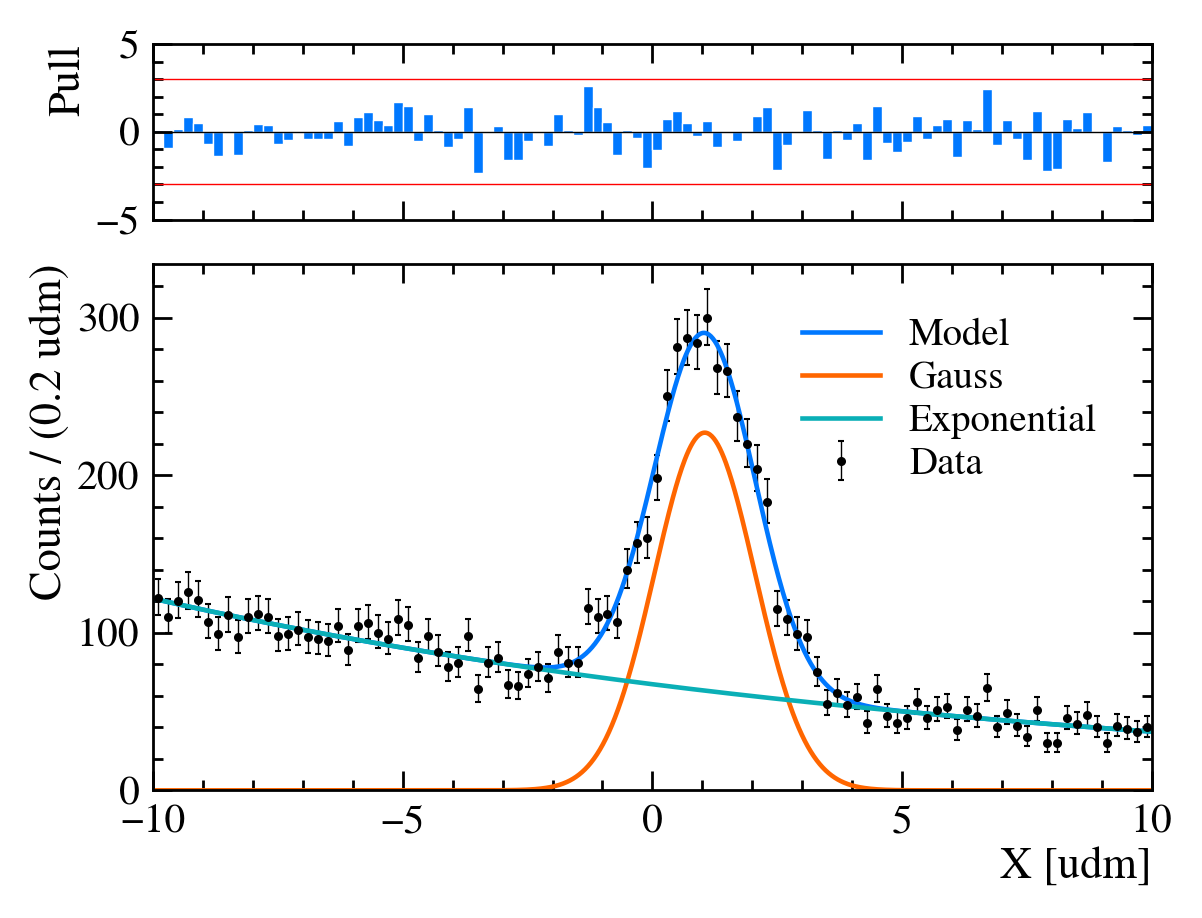

In [7]:
plotter = Plotter(data_np, model, bins=100, range=(-10,10), xlabel='X', xunit='udm')
plotter.add_component(gauss, frac, label='Gauss')
plotter.add_component(exponential, 1-frac, label='Exponential')
fig, axs = plotter.plot_fit_and_residuals()